In [35]:
from itertools import chain, repeat
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb

from hp_pred.experiments import bootstrap_test, objective_xgboost, print_one_stat, print_statistics


optuna.logging.set_verbosity(optuna.logging.WARNING)

In [36]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'bis']
STATIC_FEATURE = ["age", "bmi", "asa"]
HALF_TIME_FILTERING = [10, 60, 5*60,]

## Load and format data

In [37]:
# import the data frame and add the meta data to the segments
model_filename = 'test_bob.json'
model_filename_2 = 'test_haythem.json'
dataset = 'signal_dataset_haythem_feature_bob'
dataset_2 = 'signal_dataset_haythem'
data = pd.read_parquet(Path(f'data/datasets/{dataset}/cases/'))
static = pd.read_parquet(f'data/datasets/{dataset}/meta.parquet')
data = data.merge(static, on='caseid')

data_2 = pd.read_parquet(Path(f'data/datasets/{dataset_2}/features/'))
data_2 = data_2.merge(static, on='caseid')

train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

train_2 = data_2[data_2['split'] == "train"]
test_2 = data_2[data_2['split'] == "test"]

## Train or load existing model


In [38]:
# control reproducibility
rng_seed = 42

FEATURE_NAME = (
    [
        f"{signal}_constant_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_slope_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)
#remove feature with std_60 in the name
# FEATURE_NAME = [x for x in FEATURE_NAME if "std_60" not in x]

# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)
print(
    f"{len(train):,d} train samples, "
    f"{len(test):,d} test samples, "
    f"{test['label'].mean():.2%} positive rate."
)

# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / model_filename


if model_file.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_file)
else:
    number_fold = len(train.cv_split.unique())
    data_train_cv = [train[train.cv_split != f'cv_{i}'] for i in range(number_fold)]
    data_test_cv = [train[train.cv_split == f'cv_{i}'] for i in range(number_fold)]
    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgboost(trial, data_train_cv, data_test_cv, FEATURE_NAME),
        n_trials=25,
        show_progress_bar=True,
    )
    # get the best hyperparameters
    best_params = study.best_params

    model = xgb.XGBClassifier(**best_params)
    # refit the model with best parameters
    model.fit(train[FEATURE_NAME], train.label, verbose=1)

    # save the model
    model.save_model(model_file)

223,289 train samples, 95,524 test samples, 4.20% positive rate.


Best trial: 11. Best value: 0.166996: 100%|██████████| 25/25 [04:05<00:00,  9.82s/it]


In [39]:
# control reproducibility
rng_seed = 42

FEATURE_NAME_2 = [col for col in data_2.columns if col not in (list(static.columns) + ["time", "intervention", "label", "label_id", "time_before_IOH"])]
# FEATURE_NAME = [x for x in FEATURE_NAME if "std_60" not in x]

# create a regressor
train = train_2.dropna(subset=FEATURE_NAME_2)
test_2 = test_2.dropna(subset=FEATURE_NAME_2)
print(
    f"{len(train_2):,d} train samples, "
    f"{len(test_2):,d} test samples, "
    f"{test_2['label'].mean():.2%} positive rate."
)

# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / model_filename_2


if model_file.exists():
    model_2 = xgb.XGBClassifier()
    model_2.load_model(model_file)
else:
    number_fold = len(train.cv_split.unique())
    data_train_cv = [train_2[train_2.cv_split != f'cv_{i}'] for i in range(number_fold)]
    data_test_cv = [train_2[train_2.cv_split == f'cv_{i}'] for i in range(number_fold)]
    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgboost(trial, data_train_cv, data_test_cv, FEATURE_NAME_2),
        n_trials=25,
        show_progress_bar=True,
    )
    # get the best hyperparameters
    best_params = study.best_params

    model_2 = xgb.XGBClassifier(**best_params)
    # refit the model with best parameters
    model_2.fit(train_2[FEATURE_NAME_2], train_2.label, verbose=1)

    # save the model
    model_2.save_model(model_file)

223,289 train samples, 95,524 test samples, 4.20% positive rate.


Best trial: 15. Best value: 0.149031: 100%|██████████| 25/25 [04:55<00:00, 11.84s/it]


# Baseline evaluation

In [40]:
# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

FEATURE_NAME_BASELINE = "last_map_value"

# create a regressor
print(f"test set contains {len(test)} sample with a prevalence of {test['label'].mean()*100:.2f}% ")
test = test.dropna(subset=[FEATURE_NAME_BASELINE])

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "haytem_baseline.pkl"

if roc_results.exists() and True:
    dict_results_baseline = pickle.load(roc_results.open("rb"))
else:
    x_test = test[FEATURE_NAME_BASELINE].values
    y_test = test['label'].values
    y_pred = 1 - x_test/120
    y_label_id = test["label_id"].values

    print(f"Number of point in the test set: {len(y_test)}")
    print(f"Prevalence in the test set: {y_test.mean()*100:.2f}%")
    dict_results_baseline, tprs_interpolated, precision_interpolated = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed, strategy="max_precision", target=0.24)


    with roc_results.open("wb") as f:
        pickle.dump(dict_results_baseline, f)

    print_statistics(dict_results_baseline)

test set contains 95524 sample with a prevalence of 4.20% 


## Evaluation

In [41]:
y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test["label"].to_numpy()
y_label_ids = test["label_id"].to_numpy()

dict_results, tprs_interpolated, precision_interpolated = bootstrap_test(y_test, y_pred, y_label_ids, n_bootstraps=200, rng_seed=rng_seed, strategy="targeted_recall", target=0.237)

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "xgboost_filtered.pkl"
with roc_results.open("wb") as f:
    pickle.dump(dict_results, f)

100%|██████████| 200/200 [00:35<00:00,  5.68it/s]


In [42]:
# evaluate second model
y_pred = model_2.predict_proba(test_2[FEATURE_NAME_2])[:, 1]
y_test = test_2["label"].to_numpy()
y_label_ids = test_2["label_id"].to_numpy()

dict_results_2, tprs_interpolated_2, precision_interpolated_2 = bootstrap_test(y_test, y_pred, y_label_ids, n_bootstraps=200, rng_seed=rng_seed, strategy="targeted_recall", target=0.237)

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "xgboost_filtered_2.pkl"
with roc_results.open("wb") as f:
    pickle.dump(dict_results_2, f)



100%|██████████| 200/200 [00:37<00:00,  5.35it/s]


### Model's prediction variance

#### Variance estimation by bootstrapping

In [43]:
print('Baseline')
print_statistics(dict_results_baseline)

print('\n')
print('XGBoost Bob')

print_statistics(dict_results)

print('XGBoost Haythem')

# print_statistics(dict_results_2)


Baseline
AUC: 0.73 (0.00)
AP: 0.12 [0.12, 0.12]
AUPRC: 0.15 [0.15, 0.15]
Threshold: 0.44 [0.44, 0.44]
Recall: 30.9% [28.0%, 33.4%]
Precision: 20.5% (0.9%)
Specificity: 96.0% [95.6%, 96.4%]
NPV: 99.8% [99.8%, 99.8%]
F1-score: 24.5% [23.4%, 25.4%]


XGBoost Bob
AUC: 0.81 (0.00)
AP: 0.17 (0.00)
AUPRC: 0.23 (0.01)
Threshold: 0.27 [0.27, 0.27]
Recall: 23.7% [23.6%, 23.8%]
Precision: 30.0% [29.0%, 31.3%]
Specificity: 96.9% [96.8%, 97.1%]
NPV: 99.7% [99.7%, 99.7%]
F1-score: 26.5% (0.6%)
XGBoost Haythem


Print main statistics

### PRC Plot

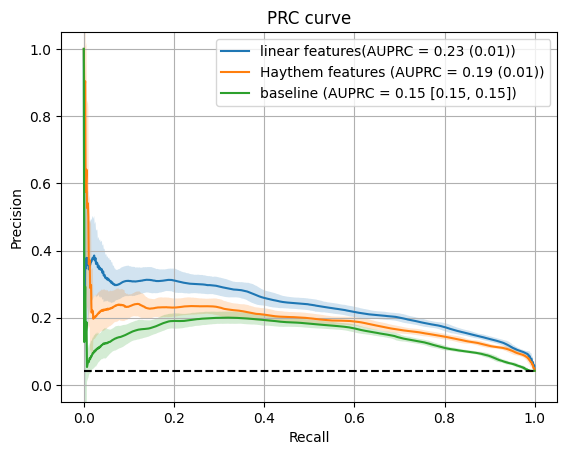

In [44]:
recall = np.linspace(0, 1, 1000)
precision_mean, precision_std = dict_results['precision'].mean(0), dict_results['precision'].std(0)
plt.fill_between(
    recall, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std, alpha=0.2
)
plt.plot(recall, precision_mean, label=f"linear features(AUPRC = {print_one_stat(pd.Series(dict_results['auprcs']),False)})")

precision_mean_2, precision_std_2 = dict_results_2['precision'].mean(0), dict_results_2['precision'].std(0)
plt.fill_between(
    recall, precision_mean_2 - 2 * precision_std_2, precision_mean_2 + 2 * precision_std_2, alpha=0.2
)
plt.plot(recall, precision_mean_2, label=f"Haythem features (AUPRC = {print_one_stat(pd.Series(dict_results_2['auprcs']),False)})")

# add baseline to the plot

plt.fill_between(
    dict_results_baseline['fprs'],
    dict_results_baseline['precision'].mean(0) - 2 * dict_results_baseline['precision'].std(0),
    dict_results_baseline['precision'].mean(0) + 2 * dict_results_baseline['precision'].std(0),
    alpha=0.2,
)
plt.plot(
    dict_results_baseline['fprs'],
    dict_results_baseline['precision'].mean(0),
    label=f"baseline (AUPRC = {print_one_stat(pd.Series(dict_results_baseline['auprcs']),False)})",
)




plt.plot([0, 1], [dict_results['precision'].mean(0)[-1]]*2, "k--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.title("PRC curve")
plt.legend()
plt.grid()
plt.show()